# GLI3

The [GLI3](https://www.omim.org/entry/165240) gene encodes a zinc finger transcription factor involved in the cilia-associated Hedgehog signalling pathway that regulates an abundance of processes in vertebrate and invertebrate biology, broadly falling into the categories of embryonic development, tissue regeneration and tumorigenesis. 

GLI3 is mainly regulated at the post-translational level. In the absence of Hedgehog-ligands it is either bound by SUFU and arrested in the cytoplasm or phosphorylated and truncated up until its N-terminal repressor domain, therefore inhibiting transcription of GLI-dependent genes. While a global knockout of SUFU leads to prenatal mortality around midgestation in mice, a conditional knockout in mesenchymal cell populations leads to polydactyly. Under Hedgehog signalling full length GLI3 can translocate into the nucleus and act as a transcriptional activator ([Yoshida S, Yoshida K. Anat Sci Int. 2024](https://pubmed.ncbi.nlm.nih.gov/39576500/)).


[Sczakiel HL, et al. (Clin Genet. 2021)](https://pubmed.ncbi.nlm.nih.gov/34482537/) distinguish three allelic, autosomally-dominant inherited disorders caused by heterozygous variants in GLI3. OMIM additionally distinguishes two subforms of non-syndromic (isolated) polysyndactyly:
1. [Greig cephalopolysyndactyly syndrome (GCPS)](https://www.omim.org/clinicalSynopsis/175700): characterized by scaphocephaly, frontal bossing, abnormalities of the corpus callosum, hypertelorism, polydactyly (pre- and postaxial) and syndactyly (central). Affected individuals usually show normal intelligence or rarely mild intellectual disability.
2. [Pallister-Hall syndrome (PHS)](https://www.omim.org/clinicalSynopsis/146510): characterized by hypothalamic hamartoma, pituitary dysfunction, polydactyly and visceral malformations. Affected individual usually show normal intelligence or rarely mild intellectual disability.
3. Isolated polysyndactyly (IPD):
   a. [Postaxial polydactyly type A1 (PAPA1) and B (PAPB)](https://www.omim.org/clinicalSynopsis/174200): can affect hands as well as feet and also include  syndactylies.
   b. [Preaxial polydactyly type IV](https://www.omim.org/clinicalSynopsis/174700): can affect feet in isolation or both hands and feet and also invole      bilateral duplication or unilateral triplication of the 5th finger as well as syndactylies. 

Several previous publications have reported candidate genotype-phenotype correlations on the GLI3 gene.

1. [Johnston JJ, et al. (Am J Hum Genet. 2005)](https://pubmed.ncbi.nlm.nih.gov/15739154/) proposes a two-fold model wherein:
    a. PHS is only caused by frameshift and splicing mutations, while GCPS is caused by most other types of mutation.
    b. Frameshift mutations within nt1–1997/AA1-660 and downstream (C-terminal) of nt3481/AA1160-1580 also cause GCPS, only frameshift mutations between nt1998–3481/AA661-1159 cause PHS.
    [Jamsheer A, et al. (J Appl Genet. 2012)](https://pubmed.ncbi.nlm.nih.gov/22903559/), [Johnston JJ, et al. (Hum Mutat. 2010)](https://pubmed.ncbi.nlm.nih.gov/20672375/) and [Patel R, et al. (Am J Med Genet A. 2021)](https://pubmed.ncbi.nlm.nih.gov/33058447/) published cohorts, supporting this hypothesis.
    
   
2. [Démurger F, et al. (Eur J Hum Genet. 2015)](https://pubmed.ncbi.nlm.nih.gov/24736735/) propose that, in the context of GPCS, corpus callosum anomalies are caused by truncating mutations in the distal third of the protein.
3. Two reviews by [Biesecker LG, et al. (Nat Genet. 1997)](https://pubmed.ncbi.nlm.nih.gov/9354780/) and [Al-Qattan MM, et al. (Clin Genet. 2017)](https://pubmed.ncbi.nlm.nih.gov/28224613/) reviewing already published cohorts postulate, that IPD only arises from variants of the C-terminal third. [Sczakiel HL, et al. (Clin Genet. 2021)](https://pubmed.ncbi.nlm.nih.gov/34482537/) published variants in other regions of the protein in patients with clinical IPD and therefore propose the absence of a genotype-phenotype correlation.


Therefore we tested frameshift mutations within the medium third of the protein together with splicing mutations against all other mutations concerning the occurence of the clinical signs ofs PHS. 
We further tested if truncating mutations (as approximated by stop-gains and frameshifts in the last exon - most likely not leading to NMD) show a correlation with the occurence of anomalies of the corpus callosum (Abnormal corpus callosum morphology - HP:0001273).
And we tested if variants in the C-terminal third show higher occurence of IPD (PAPA1/PAPB in our cohort) when compared against all other variants.

In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using gpsea version 0.9.6.dev0


### GLI3
We used the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for GLI3.

In [2]:
from gpsea.preprocessing import configure_default_protein_metadata_service

gene_symbol = 'GLI3'
mane_tx_id = 'NM_000168.6'
mane_protein_id = 'NP_000159.3' # transcriptional activator GLI3
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

In [4]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.24") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
print(f'Loaded {len(phenopackets)} phenopackets')

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
validation.summarize()

Loaded 82 phenopackets
Individuals Processed: 100%|██████████| 82/82 [00:02<00:00, 30.52 individuals/s]
Validated under permissive policy
No errors or warnings were found


In [5]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
37,Preaxial foot polydactyly
36,Postaxial hand polydactyly
32,Syndactyly
28,Macrocephaly
19,Broad thumb
18,Hypertelorism
17,Postaxial polydactyly
15,Y-shaped metacarpals
15,Y-shaped metatarsals
13,Shortening of all distal phalanges of the fingers


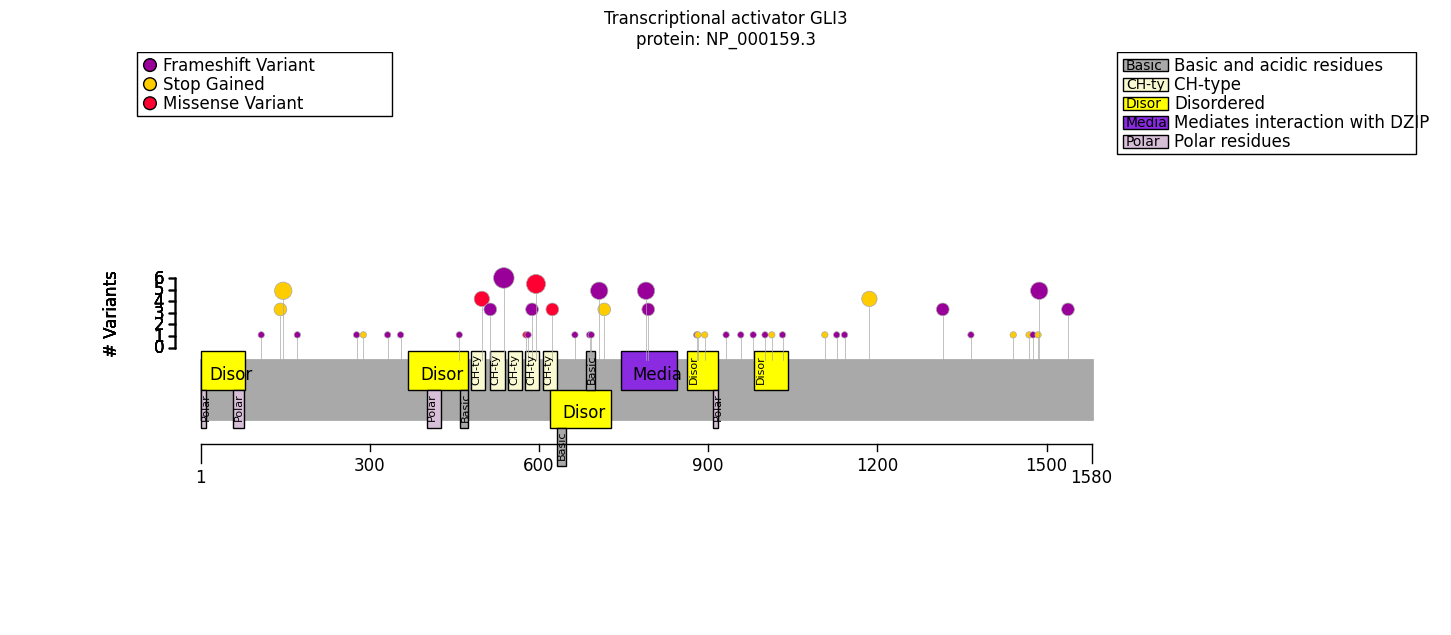

In [6]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

gli3_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=ax,
)
gli3_fig.tight_layout()

In [7]:
from gpsea.view import CohortVariantViewer

viewer = CohortVariantViewer(tx_id=mane_tx_id)
viewer.process(cohort)

Count,Variant key,HGVS,Overlapping Exons,Effects
6,7_41978628_41978630_GTC_G,c.1616_1617del (p.Arg539ThrfsTer12),11,frameshift
4,7_41967900_41967904_ACCAC_A,c.2123_2126del (p.Gly708ValfsTer24),14,frameshift
4,7_41964609_41964610_TG_T,c.4463del (p.Thr1488LysfsTer23),15,frameshift
4,7_41967654_41967655_CG_C,c.2372del (p.Pro791ArgfsTer3),14,frameshift
4,7_42076781_42076781_G_T,c.444C>A (p.Tyr148Ter),4,stop gained
3,7_41977584_41977584_G_A,c.1786C>T (p.His596Tyr),12,missense
3,SO:1000029_HGNC:4319_GLI3,SV involving GLI3 (p.?),,chromosomal deletion
3,7_41965514_41965514_G_A,c.3559C>T (p.Gln1187Ter),15,stop gained
3,7_41978748_41978748_G_A,c.1498C>T (p.His500Tyr),11,"missense, splice region"
2,7_41977583_41977583_T_G,c.1787A>C (p.His596Pro),12,missense


# Genotype-Phenotype Correlation (GPC) Analysis

In [8]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest

analysis = configure_hpo_term_analysis(hpo)

pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

### Hypothesis 1: 
Frameshift mutations within the medium third of the gene together with splicing mutations correlate with the occurence of PHS

In [9]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate import protein_region, variant_effect, allof, anyof
from gpsea.analysis.clf import monoallelic_classifier
from gpsea.view import MtcStatsViewer

is_frameshift = variant_effect(effect=VariantEffect.FRAMESHIFT_VARIANT, tx_id=mane_tx_id)
is_midregion = protein_region(region=(661,1159), tx_id=mane_tx_id)
is_fameshift_midregion = allof((is_frameshift, is_midregion))

is_splicevar = variant_effect(effect=VariantEffect.SPLICE_REGION_VARIANT, tx_id=mane_tx_id)


is_PHS_candidates = anyof ((is_fameshift_midregion, is_splicevar))
PHS_cand_label = "Fs in mid region or splice"

PHS_clf = monoallelic_classifier(
    a_predicate = is_PHS_candidates,
    b_predicate=~is_PHS_candidates,
    a_label = PHS_cand_label,
      b_label = "other",
)

PHS_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=PHS_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(PHS_result)

Reason,Count
Skip terms if all counts are identical to counts for a child term,4
"Skipping ""general"" level terms",43
Skipping terms that are rare on the cohort level (in less than 40% of the cohort members),97


In [10]:
from gpsea.view import summarize_hpo_analysis
summarize_hpo_analysis(hpo, PHS_result)

Allele group,Fs in mid region or splice,other,Corrected p values,p values
Y-shaped metatarsals [HP:0010567],11/19 (58%),4/50 (8%),0.000780,0.000033
Y-shaped metacarpals [HP:0006042],11/23 (48%),4/56 (7%),0.001193,0.000099
Nail dysplasia [HP:0002164],7/20 (35%),2/54 (4%),0.008534,0.001067
Preaxial foot polydactyly [HP:0001841],5/25 (20%),32/57 (56%),0.020893,0.003482
Anal atresia [HP:0002023],7/25 (28%),3/57 (5%),0.035701,0.007438
Postaxial polydactyly [HP:0100259],18/22 (82%),35/35 (100%),0.074074,0.018519
Macrocephaly [HP:0000256],1/9 (11%),27/49 (55%),0.089616,0.026138
Preaxial polydactyly [HP:0100258],5/9 (56%),32/38 (84%),0.241944,0.080648
Hypertelorism [HP:0000316],1/9 (11%),17/43 (40%),0.369469,0.138551
Postaxial foot polydactyly [HP:0001830],0/9 (0%),11/46 (24%),0.428964,0.178735


While no correlation was found for many PHS-typical features with splice- and midregion-frameshift-variants, the analysis showed a strong correlation to Y-shaped meta-tarsal & -carpal bones to these variants.

### Hypothesis 2: 
Stop-gain and frameshift variants in the last exon have been reported to show a correlation with the occurrence of anomalies of the corpus callosum. We can use the following code to check if our cohort reported data about the corpus callosum.

In [11]:
any([val in gpsea.model.Cohort.list_present_phenotypes(cohort) for val in hpo.graph.get_descendants("HP:0001273")])

False

Thus, the published data from which our cohort is derived doesn't report on anomalies of the corpus callosum or more specific features from the same spectrum.
We will nevertheless check if presumably truncating variants are associated with other features.

In [12]:
from gpsea.analysis.predicate import exon

is_exon15 = exon(exon=15, tx_id=mane_tx_id)
is_stopgain = variant_effect(effect=VariantEffect.STOP_GAINED, tx_id=mane_tx_id)
is_sg_fs = anyof ((is_stopgain, is_frameshift))
is_exon15_sg_fs = allof((is_exon15 , is_sg_fs))
ex15sgfs_label = "Truncating variants in Exon 15"

ex15sgfs_clf = monoallelic_classifier(
    a_predicate = is_exon15_sg_fs,
    b_predicate = ~is_exon15_sg_fs,
    a_label = ex15sgfs_label, 
    b_label = "other",
)
ex15sgfs_clf_result = analysis.compare_genotype_vs_phenotypes(
    cohort = cohort,
    gt_clf = ex15sgfs_clf,
    pheno_clfs = pheno_clfs
)
summarize_hpo_analysis(hpo, ex15sgfs_clf_result)

Allele group,Truncating variants in Exon 15,other,Corrected p values,p values
Syndactyly [HP:0001159],5/17 (29%),33/38 (87%),0.001156,0.000048
Postaxial foot polydactyly [HP:0001830],9/20 (45%),2/35 (6%),0.010688,0.000891
Anal atresia [HP:0002023],8/28 (29%),2/54 (4%),0.017264,0.002260
Macrocephaly [HP:0000256],13/16 (81%),15/42 (36%),0.017264,0.002877
Preaxial foot polydactyly [HP:0001841],7/28 (25%),30/54 (56%),0.049925,0.010401
Postaxial hand polydactyly [HP:0001162],15/20 (75%),21/45 (47%),0.228845,0.057211
Nail dysplasia [HP:0002164],5/23 (22%),4/51 (8%),0.430938,0.125690
Preaxial polydactyly [HP:0100258],7/7 (100%),30/40 (75%),0.795318,0.318458
Postaxial polydactyly [HP:0100259],23/26 (88%),30/31 (97%),0.795318,0.321549
Hypertelorism [HP:0000316],7/15 (47%),11/37 (30%),0.795318,0.336662


Thus, exon 15 truncation variants are significantly underrepresented in individuals affected by syndactyly and pre-axial foot polydactyly and overrepresented in individuals with macrocephaly and post-axial foot polydactyly.

### Hypothesis 3: 
Variants in the C-terminal third show higher occurence of IPD than variants in other regions.

In [13]:
is_termthird = protein_region(region=(1160,1580), tx_id=mane_tx_id)

termthird_clf = monoallelic_classifier(
    a_predicate = is_termthird,
    b_predicate = ~is_termthird,
    a_label = "Variants in C-terminal third", 
    b_label = "other",
) 

termthird_result = analysis.compare_genotype_vs_phenotypes(
    cohort = cohort,
    gt_clf = termthird_clf,
    pheno_clfs = pheno_clfs
)

summarize_hpo_analysis(hpo, termthird_result)

Allele group,Variants in C-terminal third,other,Corrected p values,p values
Postaxial foot polydactyly [HP:0001830],9/16 (56%),2/39 (5%),0.001764,0.000073
Syndactyly [HP:0001159],5/16 (31%),33/39 (85%),0.002698,0.000225
Postaxial hand polydactyly [HP:0001162],15/16 (94%),21/49 (43%),0.002722,0.000340
Macrocephaly [HP:0000256],13/15 (87%),15/43 (35%),0.004387,0.000731
Y-shaped metatarsals [HP:0010567],0/16 (0%),15/53 (28%),0.072152,0.015032
Y-shaped metacarpals [HP:0006042],0/16 (0%),15/63 (24%),0.129381,0.032345
Nail dysplasia [HP:0002164],0/16 (0%),9/58 (16%),0.591372,0.190984
Anal atresia [HP:0002023],0/16 (0%),10/66 (15%),0.591372,0.197124
Preaxial polydactyly [HP:0100258],6/6 (100%),31/41 (76%),0.846021,0.317258
Hypertelorism [HP:0000316],6/14 (43%),12/38 (32%),1.000000,0.519123


As hypothesized individuals with variants in the terminal third of the protein do show a higher occurrence of the features of IPD. Additionally individuals with these variant apparently show a higher occurrence of macrocephaly. 

# Summary

In [14]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

fet_results = (
    GPAnalysisResultSummary.from_multi(
        result=PHS_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=ex15sgfs_clf_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=termthird_result,
    ),
)


caption = """Genotype-Phenotype-Correlations in GLI3 have been extensive investigated, with findings being similar 
but not identical to those reported here \\cite{PMID_15739154,PMID_22903559,PMID_33058447,PMID_24736735,PMID_9354780,PMID_28224613,PMID_34482537}"""
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=fet_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [15]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

HPO Term,Fs in mid region or splice,other,p-val,adj. p-val
Preaxial foot polydactyly [HP:0001841],5/25 (20%),32/57 (56%),0.003,0.021
Y-shaped metacarpals [HP:0006042],11/23 (48%),4/56 (7%),9.94e-05,0.001
Y-shaped metatarsals [HP:0010567],11/19 (58%),4/50 (8%),3.25e-05,7.80e-04
Nail dysplasia [HP:0002164],7/20 (35%),2/54 (4%),0.001,0.009
Anal atresia [HP:0002023],7/25 (28%),3/57 (5%),0.007,0.036
HPO Term,Truncating variants in Exon 15,other,p-val,adj. p-val
Macrocephaly [HP:0000256],13/16 (81%),15/42 (36%),0.003,0.017
Preaxial foot polydactyly [HP:0001841],7/28 (25%),30/54 (56%),0.010,0.050
Syndactyly [HP:0001159],5/17 (29%),33/38 (87%),4.82e-05,0.001
Postaxial foot polydactyly [HP:0001830],9/20 (45%),2/35 (6%),8.91e-04,0.011


In [16]:
summarizer.process_latex(report=report, protein_fig=gli3_fig)

Figure saved to ../../supplement/img/GLI3_protein_diagram-draft.pdf
Output to ../../supplement/tex/GLI3_summary_draft.tex
